![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

<br>

# Plot an ensemble of CMIP6 climate projections

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-projections/main?labpath=projections-cmip6.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-projections/blob/main/projections-cmip6.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-projections/blob/main/projections-cmip6.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-projections/blob/main/projections-cmip6.ipynb)

## Learning objectives 🎯

This notebook provides a practical introduction on how to access and process [CMIP6 global climate projections](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview) data available in the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S). The workflow shows how to compute and visualize the output of an ensemble of models for the annual global average temperature between 1850 to 2100. You will use the `historical` experiment for the temporal period 1850 to 2014 and the three scenarios `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` for the period from 2015 to 2100.

Learn [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections) more about CMIP6 global climate projections and the CMIP6 experiments in the CDS.

## Prepare your environment

### Set up the CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [3]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [4]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
import os
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Specify data directory

In [5]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

## Explore data

For the sake of simplicity, and to facilitate data download, the tutorial will make use of some of the coarser resolution models that have a smaller data size. It is nevertheless only a choice for this exercise and not a recommendation (since ideally all models, including those with highest resolution, should be used). Many more models are available on the CDS, and when calculating an ensemble of models, it is best practice to use as many as possible for a more reliable output. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models,gridsandpressurelevels) a full list of models included in the CDS-CMIP6 dataset.

### Search for the data

Having selected the [CMIP6 global climate projections](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview) dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

:::{dropdown} Parameters of data to download
  
- Data: `CMIP6 global climate projections of near-surface air temperature`
- Experiments: `Historical`, `SSP1-2.6`, `SSP2-4.5`, `SSP5-8.5`
- Models: 7 models from Germany, France, UK, Japan and Russia
- Temporal range: `Historical: 1850 - 2014`. `Scenarios: 2015 - 2100`
- Spatial coverage: `Global`
- Format: `NetCDF`, compressed into zip files

:::

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below). Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory.

:::{warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

:::

### Download the data

 Below, we loop through multiple data requests. These include data for different models and scenarios. It is not possible to specify multiple models in one data request as their spatial resolution varies.

We will download monthly aggregated data. These are disseminated as netcdf files within a zip archive.

In order to loop through the various experiments and models in our data requests, we will specify them as Python 'lists' here:

In [7]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

In [8]:
models = ['hadgem3_gc31_ll', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr', 
          'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

:::{note}

Note that these are a selection of the lightest models (in terms of data volume), to facilitate download for the sake of this exercise. There are many [more models](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview") available on the CDS.

:::

Now we can download the data for each model and experiment sequentially. We will do this separately for the historical experiments and for the various future scenarios, given that they refer to two different time periods.

In [ ]:
# DOWNLOAD DATA FOR HISTORICAL PERIOD

c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

for j in models:
    c.retrieve(
        'projections-cmip6',
        {
            'download_format': 'zip',
            'data_format': 'netcdf',
            'temporal_resolution': 'monthly',
            'experiment': 'historical',
            'level': 'single_levels',
            'variable': 'near_surface_air_temperature',
            'model': f'{j}',
            'year': ["1850", "1851", "1852", "1853", "1854", "1855",
                    "1856", "1857", "1858", "1859", "1860", "1861",
                    "1862", "1863", "1864", "1865", "1866", "1867",
                    "1868", "1869", "1870", "1871", "1872", "1873",
                    "1874", "1875", "1876", "1877", "1878", "1879",
                    "1880", "1881", "1882", "1883", "1884", "1885",
                    "1886", "1887", "1888", "1889", "1890", "1891",
                    "1892", "1893", "1894", "1895", "1896", "1897",
                    "1898", "1899", "1900", "1901", "1902", "1903",
                    "1904", "1905", "1906", "1907", "1908", "1909",
                    "1910", "1911", "1912", "1913", "1914", "1915",
                    "1916", "1917", "1918", "1919", "1920", "1921",
                    "1922", "1923", "1924", "1925", "1926", "1927",
                    "1928", "1929", "1930", "1931", "1932", "1933",
                    "1934", "1935", "1936", "1937", "1938", "1939",
                    "1940", "1941", "1942", "1943", "1944", "1945",
                    "1946", "1947", "1948", "1949", "1950", "1951",
                    "1952", "1953", "1954", "1955", "1956", "1957",
                    "1958", "1959", "1960", "1961", "1962", "1963",
                    "1964", "1965", "1966", "1967", "1968", "1969",
                    "1970", "1971", "1972", "1973", "1974", "1975",
                    "1976", "1977", "1978", "1979", "1980", "1981",
                    "1982", "1983", "1984", "1985", "1986", "1987",
                    "1988", "1989", "1990", "1991", "1992", "1993",
                    "1994", "1995", "1996", "1997", "1998", "1999",
                    "2000", "2001", "2002", "2003", "2004", "2005",
                    "2006", "2007", "2008", "2009", "2010", "2011",
                    "2012", "2013", "2014"],
            "month": ["01", "02", "03", "04", "05", "06",
                      "07", "08", "09", "10", "11", "12"]    
        },
        f'{DATADIR}cmip6_monthly_1850-2014_historical_{j}.zip')

2025-07-10 10:22:10,419 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-10 10:22:11,341 INFO Request ID is d1c5881d-4936-4466-bc9b-7d3c48d65924
2025-07-10 10:22:11,593 INFO status has been updated to accepted
2025-07-10 10:22:17,013 INFO status has been updated to running
2025-07-10 10:23:27,757 INFO status has been updated to successful


f3aa26d873f8942bac9fbe2a0606b73b.zip:   0%|          | 0.00/103M [00:00<?, ?B/s]

2025-07-10 10:24:08,486 INFO Request ID is 8a781dfc-073c-4eff-8f42-1684de3813ea
2025-07-10 10:24:08,559 INFO status has been updated to accepted
2025-07-10 10:24:17,478 INFO status has been updated to running
2025-07-10 10:24:59,056 INFO status has been updated to successful


e8a37701974247b107de830eff4640b8.zip:   0%|          | 0.00/94.2M [00:00<?, ?B/s]

2025-07-10 10:25:13,872 INFO Request ID is 6cbc4ea5-c92f-46de-8c90-4b3b4705701c
2025-07-10 10:25:14,086 INFO status has been updated to accepted
2025-07-10 10:25:27,884 INFO status has been updated to running
2025-07-10 10:26:04,302 INFO status has been updated to successful


bbe496751b640d6185a3546a00c0beb1.zip:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

2025-07-10 10:26:34,562 INFO Request ID is ab6d5273-b2ba-4ad9-ad9e-a0b9cb2a6efb
2025-07-10 10:26:34,651 INFO status has been updated to accepted
2025-07-10 10:26:48,299 INFO status has been updated to running
2025-07-10 10:26:56,114 INFO status has been updated to accepted
2025-07-10 10:27:07,601 INFO status has been updated to successful


d36b9c093c54f109877e13f10845bf0.zip:   0%|          | 0.00/92.8M [00:00<?, ?B/s]

2025-07-10 10:27:20,180 INFO Request ID is 35dbd444-45d8-440e-8281-6c1b5b07f0b3
2025-07-10 10:27:20,261 INFO status has been updated to accepted
2025-07-10 10:27:53,173 INFO status has been updated to successful


7c7b4ad3bc6b6152d829001a17a1ef4a.zip:   0%|          | 0.00/36.5M [00:00<?, ?B/s]

2025-07-10 10:28:06,979 INFO Request ID is 04a38876-98ce-4e03-8eae-011f06ec3e19
2025-07-10 10:28:07,050 INFO status has been updated to accepted
2025-07-10 10:28:15,533 INFO status has been updated to running
2025-07-10 10:28:57,064 INFO status has been updated to successful


d0dfe01d1f3cfff501de15a0b1c6b599.zip:   0%|          | 0.00/58.9M [00:00<?, ?B/s]

2025-07-10 10:29:05,039 INFO Request ID is 19808302-07ea-4d29-98fa-f9f1d23ff6bb
2025-07-10 10:29:05,170 INFO status has been updated to accepted
2025-07-10 10:29:26,769 INFO status has been updated to running
2025-07-10 10:30:21,201 INFO status has been updated to successful


232a4b1c2fe0d4a2862d4a86defd8ad1.zip:   0%|          | 0.00/207M [00:00<?, ?B/s]

In [ ]:
# DOWNLOAD DATA FOR FUTURE SCENARIOS

c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

for i in experiments[1:]:
    for j in models:
        c.retrieve(
            'projections-cmip6',
            {
                'download_format': 'zip',
                'data_format': 'netcdf',
                'temporal_resolution': 'monthly',
                'experiment': f'{i}',
                'level': 'single_levels',
                'variable': 'near_surface_air_temperature',
                'model': f'{j}',
                'year': ["2015", "2016", "2017", "2018", "2019", "2020",
                         "2021", "2022", "2023", "2024", "2025", "2026",
                         "2027", "2028", "2029", "2030", "2031", "2032",
                         "2033", "2034", "2035", "2036", "2037", "2038",
                         "2039", "2040", "2041", "2042", "2043", "2044",
                         "2045", "2046", "2047", "2048", "2049", "2050",
                         "2051", "2052", "2053", "2054", "2055", "2056",
                         "2057", "2058", "2059", "2060", "2061", "2062",
                         "2063", "2064", "2065", "2066", "2067", "2068",
                         "2069", "2070", "2071", "2072", "2073", "2074",
                         "2075", "2076", "2077", "2078", "2079", "2080",
                         "2081", "2082", "2083", "2084", "2085", "2086",
                         "2087", "2088", "2089", "2090", "2091", "2092",
                         "2093", "2094", "2095", "2096", "2097", "2098",
                         "2099", "2100"],
                'month': ["01", "02", "03", "04", "05", "06",
                          "07", "08", "09", "10", "11", "12"]
            },
            f'{DATADIR}cmip6_monthly_2015-2100_{i}_{j}.zip')

2025-07-10 10:41:27,524 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-10 10:41:28,207 INFO Request ID is 14183f12-1981-4ccf-a44d-3061b3f85238
2025-07-10 10:41:28,398 INFO status has been updated to accepted
2025-07-10 10:42:01,302 INFO status has been updated to running
2025-07-10 10:42:44,186 INFO status has been updated to successful


88de36221697baac09cbbf8def6b5ed4.zip:   0%|          | 0.00/53.8M [00:00<?, ?B/s]

2025-07-10 10:42:55,747 INFO Request ID is 2d2bf80d-e701-49fe-b523-ae43dbfa10cb
2025-07-10 10:42:55,851 INFO status has been updated to accepted
2025-07-10 10:43:09,675 INFO status has been updated to running
2025-07-10 10:43:28,845 INFO status has been updated to successful


4ad79a5617d152b894ef8391fb4b3002.zip:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

2025-07-10 10:43:36,798 INFO Request ID is f212f1e8-d9bb-4886-adbd-8c7604658c3a
2025-07-10 10:43:36,860 INFO status has been updated to accepted
2025-07-10 10:43:50,505 INFO status has been updated to running
2025-07-10 10:44:53,020 INFO status has been updated to successful


bd17985269e61f1947a095bea56356aa.zip:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

2025-07-10 10:45:01,370 INFO Request ID is 4cc2aaeb-0f93-46c0-afb5-806c9f05b5c0
2025-07-10 10:45:01,934 INFO status has been updated to accepted
2025-07-10 10:45:08,357 INFO status has been updated to running
2025-07-10 10:45:25,047 INFO status has been updated to successful


5405a0e6ff6ec00130c06962805bb295.zip:   0%|          | 0.00/48.3M [00:00<?, ?B/s]

2025-07-10 10:45:34,124 INFO Request ID is 9748fa4d-8994-479e-ad63-e5ce39f87536
2025-07-10 10:45:34,195 INFO status has been updated to accepted
2025-07-10 10:45:48,279 INFO status has been updated to running
2025-07-10 10:45:55,945 INFO status has been updated to accepted
2025-07-10 10:46:07,434 INFO status has been updated to successful


31b6a1468173dbd2e81a687df080c59d.zip:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

2025-07-10 10:46:11,947 INFO Request ID is 3a1e0d08-d5f9-4c7f-ad60-d8046de650cf
2025-07-10 10:46:12,029 INFO status has been updated to accepted
2025-07-10 10:46:20,562 INFO status has been updated to running
2025-07-10 10:46:44,905 INFO status has been updated to successful


9ca443250f51c03959f08b550a136315.zip:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

2025-07-10 10:46:54,873 INFO Request ID is 2c16b7e8-69e3-4856-b00a-635da50c1b66
2025-07-10 10:46:55,010 INFO status has been updated to accepted
2025-07-10 10:47:03,849 INFO status has been updated to running
2025-07-10 10:47:45,426 INFO status has been updated to successful


42f303884ce64859b2f9508c4d7c3172.zip:   0%|          | 0.00/53.9M [00:00<?, ?B/s]

2025-07-10 10:47:54,083 INFO Request ID is e741653c-9256-4982-8c4c-3375e67bf104
2025-07-10 10:47:54,169 INFO status has been updated to accepted
2025-07-10 10:48:03,082 INFO status has been updated to running
2025-07-10 10:48:28,777 INFO status has been updated to successful


9d33f316eaed56fde8d06ce366e32293.zip:   0%|          | 0.00/53.8M [00:00<?, ?B/s]

2025-07-10 10:48:55,485 INFO Request ID is a9d12a90-31be-4cec-a251-44f12c9f94cc
2025-07-10 10:48:55,576 INFO status has been updated to accepted
2025-07-10 10:49:04,154 INFO status has been updated to running
2025-07-10 10:49:28,453 INFO status has been updated to successful


b99f7d36292ee51fc635ab5a280a851b.zip:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

2025-07-10 10:49:38,448 INFO Request ID is 260fd634-04c1-4017-9f88-50082f94b297
2025-07-10 10:49:38,533 INFO status has been updated to accepted
2025-07-10 10:49:52,159 INFO status has been updated to running
2025-07-10 10:50:11,319 INFO status has been updated to successful


44b210b74bbccfda1e9a09e128f3adea.zip:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

2025-07-10 10:50:23,618 INFO Request ID is 7752b683-d0cd-4571-8f45-34e25a2e0ef0
2025-07-10 10:50:23,687 INFO status has been updated to accepted
2025-07-10 10:50:45,038 INFO status has been updated to running
2025-07-10 10:50:56,509 INFO status has been updated to successful


7d0ca55980bd5cd07512038428798c80.zip:   0%|          | 0.00/48.2M [00:00<?, ?B/s]

2025-07-10 10:51:04,427 INFO Request ID is 065b550a-e8d2-4392-89aa-28bcc430b0ff
2025-07-10 10:51:04,515 INFO status has been updated to accepted
2025-07-10 10:51:18,419 INFO status has been updated to running
2025-07-10 10:51:37,535 INFO status has been updated to successful


3d77f8f5aaf5af56fd2b8c18ce2198ed.zip:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

2025-07-10 10:51:46,695 INFO Request ID is 22948edb-a869-4268-8697-1d8a1a2c54b4
2025-07-10 10:51:47,107 INFO status has been updated to accepted
2025-07-10 10:51:55,758 INFO status has been updated to running
2025-07-10 10:52:20,111 INFO status has been updated to successful


4600f41fcec0948992a882df5f0605d3.zip:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

2025-07-10 10:52:29,074 INFO Request ID is 02f9b3b6-437f-4402-9003-ae26ab6f3c89
2025-07-10 10:52:29,138 INFO status has been updated to accepted
2025-07-10 10:52:43,035 INFO status has been updated to running
2025-07-10 10:53:45,167 INFO status has been updated to successful


19edb6bbbc385174dfeff6c5a67a8d18.zip:   0%|          | 0.00/108M [00:00<?, ?B/s]

2025-07-10 10:54:17,843 INFO Request ID is 404cd3be-ef90-497b-93fc-2d09aaa56f6b
2025-07-10 10:54:17,949 INFO status has been updated to accepted
2025-07-10 10:54:26,517 INFO status has been updated to running
2025-07-10 10:54:50,845 INFO status has been updated to successful


d0f2eecf49378206f249358256410899.zip:   0%|          | 0.00/53.7M [00:00<?, ?B/s]

2025-07-10 10:55:04,777 INFO Request ID is d20baa69-30b4-4d90-bde3-a8c20c3f2e2f
2025-07-10 10:55:04,956 INFO status has been updated to accepted
2025-07-10 10:55:14,056 INFO status has been updated to running
2025-07-10 10:56:21,510 INFO status has been updated to successful


f6d6c20b0627044caf072290f547952f.zip:   0%|          | 0.00/66.1M [00:00<?, ?B/s]

2025-07-10 10:56:37,519 INFO Request ID is 54beaf56-504b-4351-bbd8-3deda3159403
2025-07-10 10:56:37,604 INFO status has been updated to accepted
2025-07-10 10:56:46,456 INFO status has been updated to running
2025-07-10 10:57:10,759 INFO status has been updated to successful


c7382c3920eb626dd3bade5d9a7e53db.zip:   0%|          | 0.00/50.5M [00:00<?, ?B/s]

2025-07-10 10:57:21,409 INFO Request ID is 9ab9cecf-ef9a-4d61-95a9-99a23abe4cba
2025-07-10 10:57:21,479 INFO status has been updated to accepted
2025-07-10 10:57:30,124 INFO status has been updated to running
2025-07-10 10:57:54,433 INFO status has been updated to successful


6a0846a04c983c06f07a564514a37edd.zip:   0%|          | 0.00/48.2M [00:00<?, ?B/s]

2025-07-10 10:58:02,409 INFO Request ID is 90d6ed13-5ab0-4910-ab22-8e4a898a1325
2025-07-10 10:58:02,522 INFO status has been updated to accepted
2025-07-10 10:58:11,124 INFO status has been updated to running
2025-07-10 10:58:35,719 INFO status has been updated to successful


908ef86dbb44e7fffceef1f0924eab14.zip:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

2025-07-10 10:58:41,631 INFO Request ID is 1ba3e0f4-c0ee-40cc-9364-ad42fc44f1a5
2025-07-10 10:58:41,703 INFO status has been updated to accepted
2025-07-10 10:58:50,112 INFO status has been updated to running
2025-07-10 10:59:14,676 INFO status has been updated to successful


7c3d773fbb73ef019d9fce25db7b0484.zip:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

2025-07-10 10:59:19,284 INFO Request ID is c4b7b269-5a80-4ed4-ad0f-27e0ab7e71bc
2025-07-10 10:59:19,367 INFO status has been updated to accepted
2025-07-10 10:59:27,824 INFO status has been updated to running
2025-07-10 10:59:52,099 INFO status has been updated to successful


14e27ef0274c2e9328c34180fd017446.zip:   0%|          | 0.00/53.8M [00:00<?, ?B/s]

## Unzip the downloaded data files

From the CDS, CMIP6 data are available as `NetCDF` files compressed into `zip` archives. For this reason, before we can load any data, we have to extract the files. Having downloaded the four experiments `historical`, `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` as seperate zip files, we can use the functions from the `zipfile` Python package to extract their contents. For each zip file we first construct a `ZipFile()` object, then we apply the function `extractall()` to extract its content.

In [11]:
cmip6_zip_paths = glob(f'{DATADIR}*.zip')
for j in cmip6_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

### Create a list of the extracted files

To facilitate batch processing later in the tutorial, here we create a list of the extracted NetCDF files:

In [12]:
cmip6_nc = list()
cmip6_nc_rel = glob(f'{DATADIR}tas*.nc')
for i in cmip6_nc_rel:
    cmip6_nc.append(os.path.basename(i))

We will briefly inspect this list by printing the first five elements, corresponding to the filenames of a sample of the extracted NetCDF files:

In [13]:
cmip6_nc[0:5]

['tas_Amon_MIROC-ES2L_ssp245_r1i1p1f2_gn_20150116-21001216.nc',
 'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_20150116-21001216.nc',
 'tas_Amon_INM-CM4-8_ssp585_r1i1p1f1_gr1_20150116-21001216.nc',
 'tas_Amon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_20150116-21001216.nc',
 'tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500116-20141216.nc']

## Load and prepare CMIP6 data for one model and one experiment

Now that we have downloaded and extracted the data, we can prepare it in order to view a time series of the spread of annual global temperature for the model ensemble. These preparation steps include the following:

1. **Spatial aggregation**: to have a single global temperature value for each model/experiment dataset, and for each time step
2. **Temporal aggregation**: from monthly to yearly
3. **Conversion of temperature units** from degrees Kelvin to Celsius
4. **Addition of data dimensions** in preparation for the merging of datasets from different models and experiments

In this section we apply these steps to a single dataset from one model and one experiment. In the next section we merge data from all models/experiments in preparation for the final processing and plotting of the temperature time series.

### Load and inspect data

We begin by loading the first of the NetCDF files in our list. We will use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read NetCDF files.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `lat`, `lon`, `time`, of which the dimension `bnds` is not callable.

In [14]:
ds = xr.open_dataset(f'{DATADIR}{cmip6_nc[0]}')
ds

<xarray.Dataset> Size: 34MB
Dimensions:    (time: 1032, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T1...
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 17kB ...
    lat_bnds   (lat, bnds) float64 1kB ...
    lon_bnds   (lon, bnds) float64 2kB ...
    tas        (time, lat, lon) float32 34MB ...
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          2019-07-13T17:51:22Z
    ...                     ...
    title:                  MIROC-ES2L output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by MIROC is licensed un...
    cmor_version:           3.3.2
    tracking_id:            hdl:21.14100/64908c82-4662-4463-ad38-5973765855a4

By examining the data above, we can see from the temporal range (1850 to 2014) that it is from the `historical` experiment.

We see that the data dimensions have been given labelled coordinates of time, latitude and longitude. We can find more about the dataset from the `Attributes`, such information includes the model name, description of the variable (`long_name`), units, etc.

Some of this information we will need later, this includes the experiment and model IDs. We will save these into variables:

In [15]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

An `xarray.Dataset()` may contain arrays of multiple variables. We only have one variable in the dataset, which is near-surface air temperature, `tas`. Below we create an `xarray.DataArray()` object, which takes only one variable, but gives us more flexibility in processing.

In [16]:
da = ds['tas']

### Spatial aggregation

The next step is to aggregate the temperature values spatially (i.e. average over the latitude and longitude dimensions) and compute the global monthly near-surface temperature.

A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes. 

This can be implemented by first calculating weights as a function of the cosine of the latitude, then applying these weights to the data array with the xarray function `weighted()`:

In [17]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

The next step is then to compute the mean across the latitude and longitude dimensions of the weighted data array with the function `mean()`. The result is a DataArray with one dimension (`time`).

In [18]:
da_agg = da_weighted.mean(['lat', 'lon'])

### Temporal aggregation

We now aggregate the monthly global near-surface air temperature values to annual global near-surface air temperature values. This operation can be done in two steps: first, all the values for one specific year have to be grouped with the function `groupby()` and second, we can create the average of each group with the function `mean()`.

The result is a one-dimensional DataArray. Please note that this operation changes the name of the dimension from `time` to `year`.

In [19]:
da_yr = da_agg.groupby('time.year').mean()

### Conversion from Kelvin to Celsius

The metadata of the original data (before it was stripped during the subsequent processing steps) tells us that the near-surface air temperature data values are in units of Kelvin. We will convert them to degrees Celsius by subtracting 273.15 from the data values. 

In [20]:
da_yr = da_yr - 273.15

### Create additional data dimensions (to later combine data from multiple models & experiments)

Finally, we will create additional dimensions for the model and for the experiment. These we will label with the model and experiment name as taken from the metadata of the original data (see above). These will be useful when we repeat the processes above for all models and experiments, and combine them into one array.

In [21]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

## Load and prepare CMIP6 data for all models and experiments

To repeat the steps above for all models and all experiments, we will collect all of the commands we have used so far into a function, which we can then apply to a batch of files corresponding to the data from all models and experiments.

In [22]:
# Function to aggregate in geographical lat lon dimensions

def geog_agg(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da_agg.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

Now we can apply this function to all the extracted NetCDF files. The `try` and `except` clauses ensure that all NetCDF files are attempted, even if some fail to be processed. One reason why some may fail is if the data are labelled differently, e.g. the model *MCM-UA-1-0* has coordinates labelled as "*latitude*" and *longitude*". This differs from the suggested standard, and more commonly applied labels of "*lat*" and "*lon*". Any that fail will be recorded in a print statement, and these can be processed separately. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-QualitycontroloftheCDS-CMIP6subset) more details on the quality control of the CMIP6 datasets on the CDS.

In [23]:
for i in cmip6_nc:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

In the absence of any print statements, we see that all files were successfully processed. 

We will now combine these processed files into one dataset for the final steps to create a visualisation of near-surface air temperature from the model ensemble.

If all files have the same coordinates, the function `xarray.open_mfdataset` will merge the data according to the same coordinates.

In [24]:
data_ds = xr.open_mfdataset(f'{DATADIR}cmip6_agg*.nc')

The dataset created by `xarray.open_mfdataset` is by default in the form of "lazy Dask arrays". 

Dask divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory. As opposed to eager evaluation, operations on Dask arrays are lazy, i.e. operations queue up a series of tasks mapped over blocks, and no computation is performed until you request values to be computed. For more details, see https://xarray.pydata.org/en/stable/user-guide/dask.html. 

To facilitate further processing we would need to convert these Dask arrays into in-memory "eager" arrays, which we can do by using the `load()` method: 

In [25]:
data_ds.load()

<xarray.Dataset> Size: 59kB
Dimensions:     (experiment: 4, model: 7, year: 251)
Coordinates:
  * year        (year) int64 2kB 1850 1851 1852 1853 ... 2097 2098 2099 2100
  * model       (model) <U15 420B 'HadGEM3-GC31-LL' ... 'UKESM1-0-LL'
  * experiment  (experiment) <U10 160B 'historical' 'ssp126' 'ssp245' 'ssp585'
    height      (model) float64 56B 1.5 2.0 2.0 2.0 2.0 2.0 1.5
Data variables:
    tas         (experiment, model, year) float64 56kB 13.58 13.62 ... 20.63

Finally, we create an Xarray DataArray object for the near-surface air temperature variable, 'tas':

In [26]:
data = data_ds['tas']

## Visualize the CMIP6 annual global average temperature between 1850 and 2100

We will now create a plot of the model ensemble of near-surface air temperature for the historical and future periods, according to the three selected scenarios.

#### Calculate quantiles for model ensemble

Rather than plotting the data from all models, we will instead view the range of values as given by quantiles, including the 10th (near to lower limit), the 50th (mid-range) and the 90th (near to upper limit) quantiles:

In [27]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


> **Note:** The warning message is due to the presence of NaN (Not a Number) data given that the historical and scenario datasets represent only parts (historical and future respectively) of the entire time series. As these two datasets have been merged, NaN values will exist (e.g. there will be no data for the historical experiment for the future period).

### View time-series

Finally we will visualise this data in one time-series plot. We will use the matplotlib function `plot()`. The dimension `year` will be the x-axis and the near-surface air temperature values in degrees Celsius will be the y-axis. 

The plotting function below has four main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.subplots()`
* **Plot the time-series**: plot the data for each experiment, including the historical experiment and three scenarios with the `plot()` function
* **Set axes limits, labels, title and legend**: Define title and axes labels, and add additional items to the plot, such as legend or gridlines
* **Save the figure**: Save the figure as a PNG file with the `matplotlib.pyplot.savefig()` function

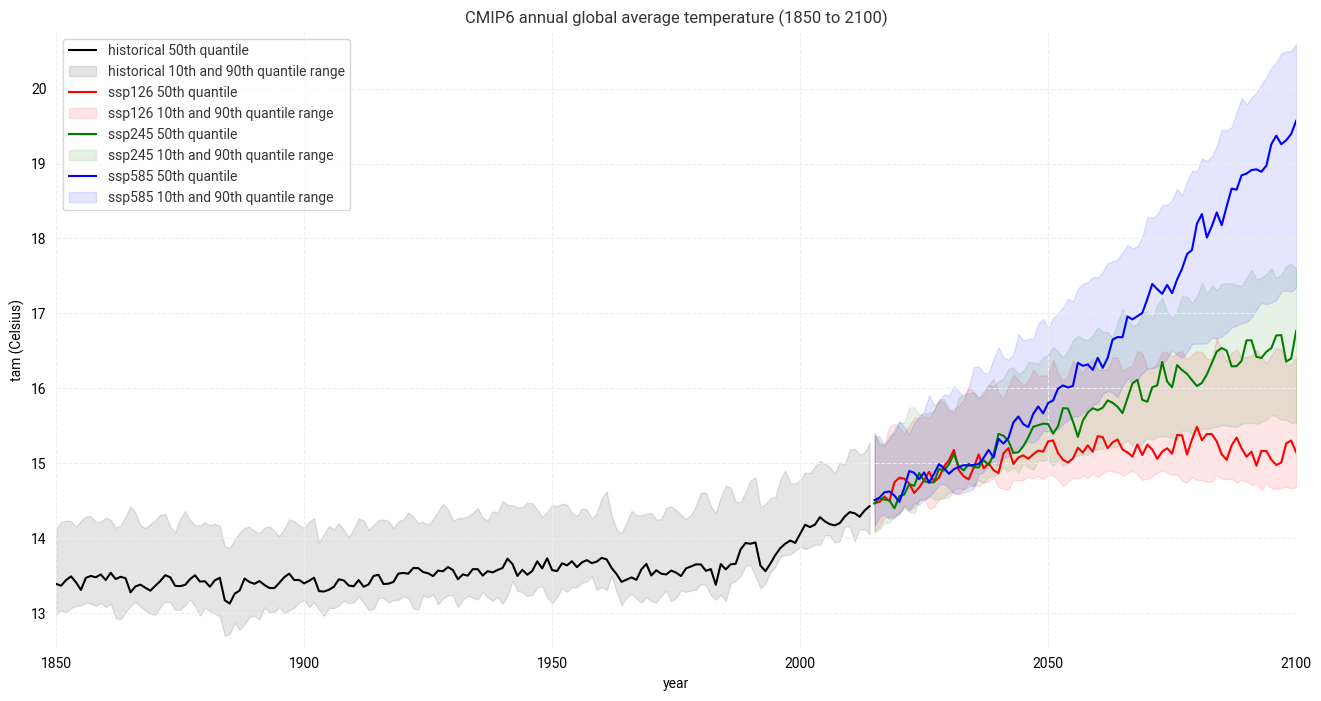

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 annual global average temperature (1850 to 2100)')
ax.set_ylabel('tam (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

The visualization of the `CMIP6 annual global average temperature (1850 to 2100)` above shows that the global average temperature was more or less stable in the pre-industrial phase, but steadily increases since the 1990s. It shows further that, depending on the SSP scenario, the course and increase of the global annual temperature differs. While for the best case `SSP1-2.6` scenario, the global annual temperature could stabilize around 15 degC, in the worst case `SSP5-8.5` scenario, the global annual temperature could increase to above 20 degC.

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>